In [1]:
import numpy as np
# import astropy.units as u
# from astropy.cosmology import FlatLambdaCDM

from modelVelocity import ModelVelocity
from logProb import log_prob
from MCMC import MCMC
from readData import ReadData

#from multiprocessing import get_context
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
#Read the measurements. 
data = ReadData(use_average_beam_axes=True)
sigma_obs = data.sigma_obs
sigma_obs_err = data.sigma_obs_err
r_ins = data.r_ins
r_outs = data.r_outs
sigma_Bs = data.sigma_Bs

In [3]:
#Initialize the modeling object
modelv = ModelVelocity(sigma_Bs, r_ins, r_outs)

In [4]:
#Initial guesses. Order is n, log Mbulge, re bulge, log Mbh
x_init = np.array([4.0, 10.5, 1.5, 1.])

#Set the bounds.
x_min = np.array([0.50,  8., 0.25, 0.])
x_max = np.array([10.0, 12., 10.0, 11.])

#Set which parameters are fixed.
ifix  = np.zeros(x_init.shape, dtype=bool)
#ifix[0] = True
#ifix[2] = True
ifix[3] = True

In [5]:
#Run the MCMC
myMCMC = MCMC(x_init, x_min, x_max, modelv, log_prob, sigma_obs, sigma_obs_err, ifix=ifix)
myMCMC.runMCMC()

100%|██████████| 2000/2000 [03:18<00:00, 10.08it/s]


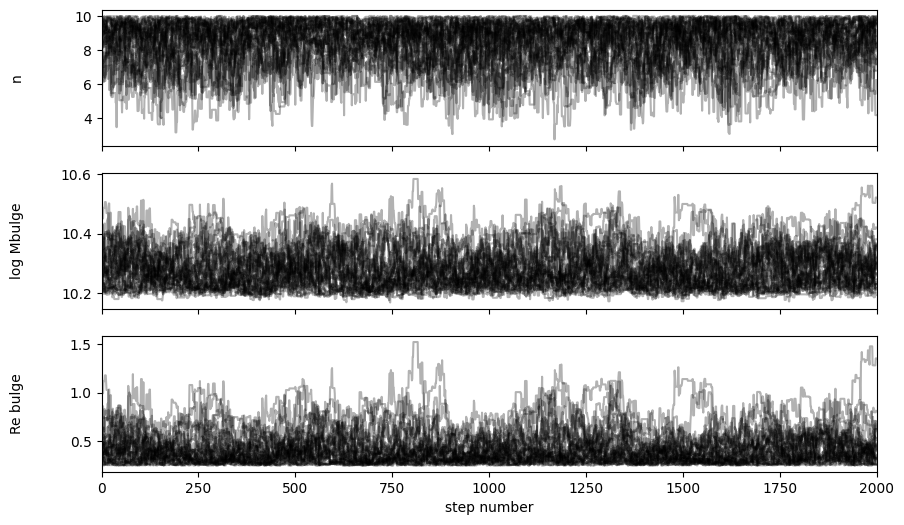

In [6]:
myMCMC.plotConvergence()

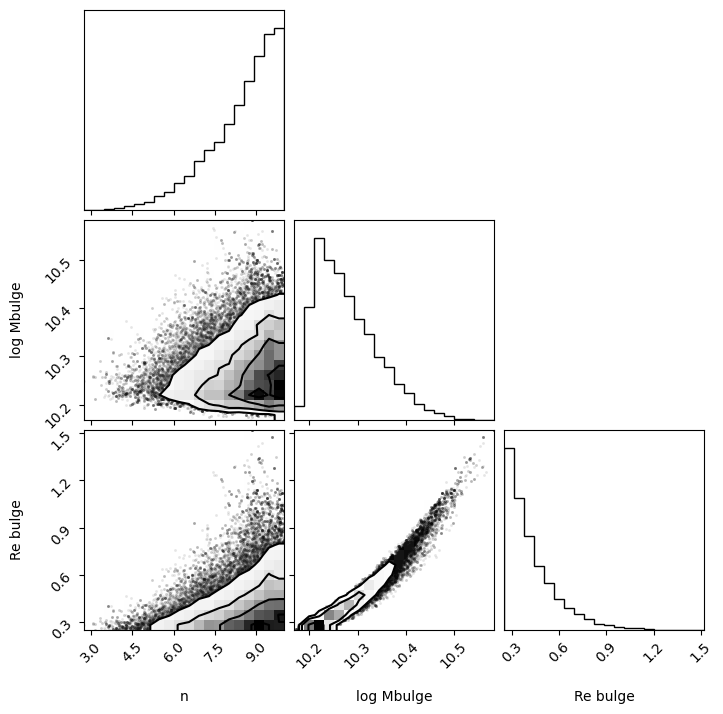

In [7]:
myMCMC.corner_plot()

In [8]:
myMCMC.best_fit()

(array([ 8.77967841, 10.26518848,  0.37482697,  1.        ]),
 array([1.57937891, 0.04962632, 0.09180218, 0.        ]),
 array([0.86356951, 0.0801098 , 0.19305232, 0.        ]),
 -4.586855145471676)

In [ ]:
chi2 = myMCMC.best_fit()[-1] * -2
chi2_nu = chi2/(len(sigma_obs)-(4-np.sum(ifix)))
print("{:.2f} {:.2f}".format(chi2, chi2_nu))

9.17 2.29


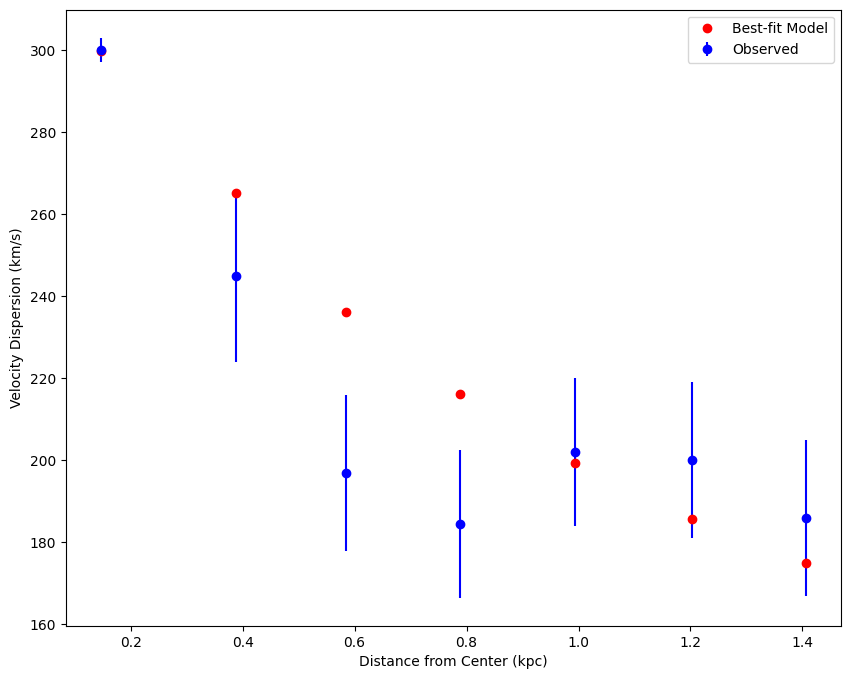

In [9]:
myMCMC.plot_bestfit()

In [10]:
myMCMC.save_flat_samples("MCMC_noMBH_flatchain.average_beam.txt")